In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
sc.settings.verbosity = 0
import scipy
#from numpy.linalg import svd
import gseapy as gp

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

In [3]:
try:
    from sys import path as syspath
    from os import path as ospath
    syspath.append(ospath.join(ospath.expanduser("~"), 'Documents/git/Xct'))

    from scTenifoldXct.main import *
    import scTenifoldXct.dNN as dNN    
    import scTenifoldXct.visualization as vis
    
except ImportError:
    print('Module not found')

In [4]:
ada = sc.read_h5ad("../data/lung_processed.h5ad")
ada

AnnData object with n_obs × n_vars = 4356 × 3000
    obs: 'cell_well', 'batch', 'n_genes', 'leiden', 'cell_type', 'ident'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'n_cells'
    uns: 'batch_colors', 'cell_type_colors', 'ident_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'log1p', 'raw'
    obsp: 'connectivities', 'distances'

In [5]:
ada.obs['ident'].value_counts()

Basophil_KO                 1284
Basophil_WT                 1152
Macrophage2                  489
Neutrophil                   315
Endothelium                  294
Matrix fibroblast            154
AT1                          117
Smooth muscle fibroblast     110
Macrophage1                  101
T cell                        97
AT2                           92
Basophil                      82
B cell                        69
Name: ident, dtype: int64

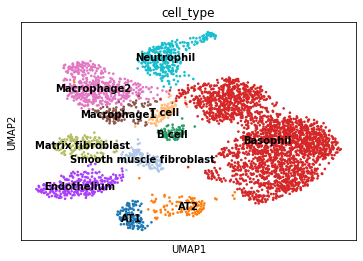

In [6]:
sc.pl.umap(ada, color='cell_type', legend_loc='on data')

## WT & KO obj:

In [7]:
# obj1 = Xct(ada, 'AT2', 'Basophil_WT', build_GRN = True, save_GRN = True, 
#            pcNet_name = 'net_AT2Baso_WT', mode = 'full', verbose = True)

obj1 = Xct(ada, 'AT2', 'Basophil_WT', specis='Mouse' ,build_GRN = False,
           pcNet_name = 'net_AT2Baso_WT')

print(obj1)

Xct object for interactions from AT2 (92) to Basophil_WT (1152)
# of genes = 3000 X 3000 
Correspondence = 6000 X 6000


In [8]:
df1 = obj1.fill_metric()
len(df1)

785

In [9]:
# obj2 = Xct(ada, 'AT2', 'Basophil_KO', build_GRN = True, save_GRN = True,
#            pcNet_name = 'net_AT2Baso_KO', mode = 'full', verbose = True)

obj2 = Xct(ada, 'AT2', 'Basophil_KO', specis = 'Mouse', build_GRN = False,
           pcNet_name = 'net_AT2Baso_KO')

print(obj2)

Xct object for interactions from AT2 (92) to Basophil_KO (1284)
# of genes = 3000 X 3000 
Correspondence = 6000 X 6000


In [10]:
df2 = obj2.fill_metric()
len(df2)

720

In [11]:
#selected LR pairs
candidates1 = get_candidates(df1)
print(len(candidates1))

candidates2 = get_candidates(df2)
print(len(candidates2))

785
720


In [12]:
candidates_union = list(set(candidates1).union(set(candidates2)))
len(candidates_union)

817

In [13]:
candidates_inter = list(set(candidates1).intersection(set(candidates2)))
len(candidates_inter)

688

In [14]:
obj1._w.shape, obj2._w.shape

((6000, 6000), (6000, 6000))

1:

In [33]:
counts_np1 = get_counts_np(obj1)
len(counts_np1), counts_np1[0].shape, counts_np1[1].shape

(2, (3000, 92), (3000, 1152))

In [34]:
projections1, losses1 = dNN.train_and_project(counts_np1, obj1._w, dim = 2, steps = 1000, lr = 0.01)

Net(
  (linear1): Linear(in_features=92, out_features=52, bias=True)
  (linear2): Linear(in_features=52, out_features=13, bias=True)
  (linear3): Linear(in_features=13, out_features=2, bias=True)
)
Net(
  (linear1): Linear(in_features=1152, out_features=192, bias=True)
  (linear2): Linear(in_features=192, out_features=48, bias=True)
  (linear3): Linear(in_features=48, out_features=2, bias=True)
)
1 7632.52001953125
10 1905.41064453125
20 1474.177734375
30 1332.9832763671875
40 1164.24853515625
50 1111.16796875
60 1079.255859375
70 1064.153076171875
80 1051.302734375
90 1043.4425048828125
100 1038.3546142578125
110 1034.533935546875
120 1031.8314208984375
130 1029.7919921875
140 1028.24072265625
150 1026.975830078125
160 1025.9541015625
170 1025.071533203125
180 1024.3150634765625
190 1023.66259765625
200 1023.1007690429688
210 1022.6148071289062
220 1022.1906127929688
230 1021.8238525390625
240 1021.4973754882812
250 1021.2182006835938
260 1021.070068359375
270 1020.7893676757812
280 1

In [35]:
df_nn1 = nn_aligned_dist(obj1, projections1)
df_nn1

computing pair-wise euclidean distances...
adding column 'correspondence'...


,ligand,receptor,dist,correspondence
Sftpc_Sftpc,Sftpc,Sftpc,0.001637,799.811829
Sftpc_Ngp,Sftpc,Ngp,0.013333,16.784599
Sftpc_Hbb-b1,Sftpc,Hbb-b1,0.003362,3949.006836
Sftpc_Hbb-b2,Sftpc,Hbb-b2,0.003310,1913.099243
Sftpc_Hba-a1,Sftpc,Hba-a1,0.003356,2579.580566
...,...,...,...,...
AF064781_Gm10642,AF064781,Gm10642,0.032024,0.003131
AF064781_Tesk2,AF064781,Tesk2,0.035011,0.000000
AF064781_2410133F24Rik,AF064781,2410133F24Rik,0.031587,0.004649
AF064781_Ccl11,AF064781,Ccl11,0.033843,0.000879


In [36]:
df_enriched1 = chi2_test(df_nn1, df = 1, pval = 0.05, FDR = True, candidates = candidates1)

df_enriched1


Total enriched: 0 / 9000000


,ligand,receptor,dist,correspondence,p_val,q_val,enriched_rank


2:

In [37]:
counts_np2 = get_counts_np(obj2)
len(counts_np2), counts_np2[0].shape, counts_np2[1].shape

(2, (3000, 92), (3000, 1284))

In [38]:
projections2, losses2 = dNN.train_and_project(counts_np2, obj2._w, dim = 2, steps = 1000, lr = 0.01)

Net(
  (linear1): Linear(in_features=92, out_features=52, bias=True)
  (linear2): Linear(in_features=52, out_features=13, bias=True)
  (linear3): Linear(in_features=13, out_features=2, bias=True)
)
Net(
  (linear1): Linear(in_features=1284, out_features=200, bias=True)
  (linear2): Linear(in_features=200, out_features=50, bias=True)
  (linear3): Linear(in_features=50, out_features=2, bias=True)
)
1 6322.44921875
10 2140.260498046875
20 1440.9891357421875
30 1107.103271484375
40 1077.7659912109375
50 1025.4893798828125
60 1003.0162353515625
70 988.1563720703125
80 980.8161010742188
90 976.5869140625
100 973.3917236328125
110 971.063720703125
120 969.28076171875
130 967.8652954101562
140 966.75439453125
150 965.8773193359375
160 965.0516967773438
170 964.3488159179688
180 963.7169799804688
190 963.2540893554688
200 962.82080078125
210 962.4449462890625
220 962.0924072265625
230 961.7865600585938
240 961.5501708984375
250 961.3331909179688
260 961.0934448242188
270 960.9154663085938
280 9

In [39]:
df_nn2 = nn_aligned_dist(obj2, projections2)
df_nn2

computing pair-wise euclidean distances...
adding column 'correspondence'...


,ligand,receptor,dist,correspondence
Sftpc_Sftpc,Sftpc,Sftpc,0.001077,524.500427
Sftpc_Ngp,Sftpc,Ngp,0.015860,3.958462
Sftpc_Hbb-b1,Sftpc,Hbb-b1,0.002653,1849.531982
Sftpc_Hbb-b2,Sftpc,Hbb-b2,0.002021,948.579529
Sftpc_Hba-a1,Sftpc,Hba-a1,0.002223,1186.088013
...,...,...,...,...
AF064781_Gm10642,AF064781,Gm10642,0.032314,0.002015
AF064781_Tesk2,AF064781,Tesk2,0.033321,0.000827
AF064781_2410133F24Rik,AF064781,2410133F24Rik,0.032410,0.001806
AF064781_Ccl11,AF064781,Ccl11,0.033384,0.000788


In [40]:
df_enriched2 = chi2_test(df_nn2, df = 1, pval = 0.05, FDR = True, candidates = candidates2)

df_enriched2


Total enriched: 0 / 9000000


,ligand,receptor,dist,correspondence,p_val,q_val,enriched_rank


merged:

In [15]:
counts_np1 = get_counts_np(obj1, obj2)
len(counts_np1), counts_np1[0].shape, counts_np1[1].shape, counts_np1[2].shape, counts_np1[3].shape

(4, (3000, 92), (3000, 1152), (3000, 92), (3000, 1284))

In [16]:
W = build_W(obj1, obj2)
W.shape

(12000, 12000)

In [18]:
projections, losses = dNN.train_and_project(counts_np1, w = W, dim = 2, steps = 1000, lr = 0.01)

Net(
  (linear1): Linear(in_features=92, out_features=52, bias=True)
  (linear2): Linear(in_features=52, out_features=13, bias=True)
  (linear3): Linear(in_features=13, out_features=2, bias=True)
)
Net(
  (linear1): Linear(in_features=1152, out_features=192, bias=True)
  (linear2): Linear(in_features=192, out_features=48, bias=True)
  (linear3): Linear(in_features=48, out_features=2, bias=True)
)
Net(
  (linear1): Linear(in_features=92, out_features=52, bias=True)
  (linear2): Linear(in_features=52, out_features=13, bias=True)
  (linear3): Linear(in_features=13, out_features=2, bias=True)
)
Net(
  (linear1): Linear(in_features=1284, out_features=200, bias=True)
  (linear2): Linear(in_features=200, out_features=50, bias=True)
  (linear3): Linear(in_features=50, out_features=2, bias=True)
)
1 13557.9423828125
10 5190.01611328125
20 3834.32177734375
30 1807.6024169921875
40 1580.1788330078125
50 1346.8228759765625
60 1205.780029296875
70 1104.223388671875
80 1051.4234619140625
90 1035.187

In [19]:
projections.shape

(12000, 2)

In [20]:
projections_split = np.array_split(projections, 2) #return a list of ndarray
projections_split[0].shape, projections_split[1].shape

((6000, 2), (6000, 2))

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig, ax = plt.subplots(figsize=(12,12), dpi=80)
ax = Axes3D(fig)


ax.scatter(projections_split[0][:3000, 0], projections_split[0][:3000, 1], projections_split[0][:3000, 2], c='red')
ax.scatter(projections_split[0][3000:, 0], projections_split[0][3000:, 1], projections_split[0][3000:, 2], c='blue')

ax.scatter(projections_split[1][:3000, 0], projections_split[1][:3000, 1], projections_split[1][:3000, 2], c='black')
ax.scatter(projections_split[1][3000:, 0], projections_split[1][3000:, 1], projections_split[1][:3000, 2], c='green')


plt.show()

In [21]:
df_nn1 = nn_aligned_dist(obj1, projections_split[0])
df_nn2 = nn_aligned_dist(obj2, projections_split[1])

df_nn1.head()

computing pair-wise euclidean distances...
adding column 'correspondence'...
computing pair-wise euclidean distances...
adding column 'correspondence'...


,ligand,receptor,dist,correspondence
Sftpc_Sftpc,Sftpc,Sftpc,0.001752,799.811829
Sftpc_Ngp,Sftpc,Ngp,0.009360,16.784599
Sftpc_Hbb-b1,Sftpc,Hbb-b1,0.002651,3949.006836
Sftpc_Hbb-b2,Sftpc,Hbb-b2,0.002503,1913.099243
Sftpc_Hba-a1,Sftpc,Hba-a1,0.002480,2579.580566


In [22]:
df_nn2.head()

,ligand,receptor,dist,correspondence
Sftpc_Sftpc,Sftpc,Sftpc,0.000744,524.500427
Sftpc_Ngp,Sftpc,Ngp,0.010472,3.958462
Sftpc_Hbb-b1,Sftpc,Hbb-b1,0.001849,1849.531982
Sftpc_Hbb-b2,Sftpc,Hbb-b2,0.001458,948.579529
Sftpc_Hba-a1,Sftpc,Hba-a1,0.001706,1186.088013


In [30]:
df_nn_all = nn_aligned_dist_diff(df_nn2, df_nn1)

df_nn_all

computing pair-wise distance differences...
adding column 'diff2'...


,ligand,receptor,dist,correspondence,dist,correspondence,diff2
Sftpc_Sftpc,Sftpc,Sftpc,0.000744,524.500427,0.001752,799.811829,1.017286e-06
Sftpc_Ngp,Sftpc,Ngp,0.010472,3.958462,0.009360,16.784599,1.235248e-06
Sftpc_Hbb-b1,Sftpc,Hbb-b1,0.001849,1849.531982,0.002651,3949.006836,6.423995e-07
Sftpc_Hbb-b2,Sftpc,Hbb-b2,0.001458,948.579529,0.002503,1913.099243,1.091515e-06
Sftpc_Hba-a1,Sftpc,Hba-a1,0.001706,1186.088013,0.002480,2579.580566,5.989460e-07
...,...,...,...,...,...,...,...
AF064781_Gm10642,AF064781,Gm10642,0.022831,0.002015,0.022182,0.003131,4.215752e-07
AF064781_Tesk2,AF064781,Tesk2,0.023912,0.000827,0.024085,0.000000,3.001777e-08
AF064781_2410133F24Rik,AF064781,2410133F24Rik,0.023028,0.001806,0.022226,0.004649,6.429180e-07
AF064781_Ccl11,AF064781,Ccl11,0.024235,0.000788,0.023677,0.000879,3.109834e-07


In [ ]:
df_nn_all.loc['Il33_Il1rl1', :]

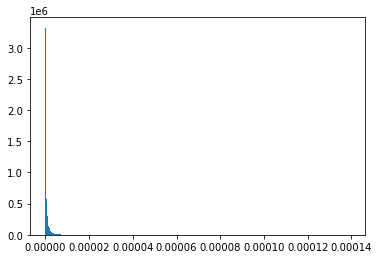

In [31]:
plt.hist(df_nn_all['diff2'], bins=1000)
plt.show()

In [ ]:
# df_nn_filtered = filtered_nn_aligned_dist(df_nn_all, candidates_union)
# df_nn_filtered.head()

In [32]:
df_enriched_diff = chi2_diff_test(df_nn_all, df=1, pval=0.05, FDR=True, candidates=candidates_union)
df_enriched_diff


Total enriched: 7 / 9000000


,ligand,receptor,dist,correspondence,dist,correspondence,diff2,p_val,q_val,enriched_rank,dir,dir_sign
Il33_Il1rl1,Il33,Il1rl1,0.015893,0.000000,0.004410,8.879311,0.000132,0.000000,0.000000,1,0,↓
Edn1_Ednrb,Edn1,Ednrb,0.014721,0.080284,0.010369,1.031674,0.000019,0.000002,0.005184,2,0,↓
Edn3_Ednrb,Edn3,Ednrb,0.015019,0.055208,0.010703,0.709435,0.000019,0.000003,0.005367,3,0,↓
Csf2_Tnf,Csf2,Tnf,0.010881,0.248127,0.006923,3.329928,0.000016,0.000018,0.014236,4,0,↓
Csf1_Tnf,Csf1,Tnf,0.012616,0.165156,0.008673,2.216438,0.000016,0.000020,0.014854,5,0,↓
Stc1_Tnf,Stc1,Tnf,0.012230,0.159443,0.008297,2.139763,0.000015,0.000021,0.015121,6,0,↓
Angpt1_Tnf,Angpt1,Tnf,0.014315,0.054766,0.010416,0.734972,0.000015,0.000024,0.015568,7,0,↓


#### GSEA:

In [26]:
genelist = get_genelist(df_enriched_diff)
len(genelist)

10

In [28]:
import gseapy as gp

enr = gp.enrichr(gene_list= genelist,
                 gene_sets='GO_Biological_Process_2021',
                 organism='Human', 
                 outdir=None, #'enrichr_kegg',
                 no_plot=True,
                 cutoff=0.05 
                )

In [29]:
enr.results.head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,vascular associated smooth muscle contraction ...,3/8,5.033266e-09,0.000002,0,0,1713.000000,32730.628194,EDN1;EDNRB;EDN3
1,GO_Biological_Process_2021,vasoconstriction (GO:0042310),3/11,1.481876e-08,0.000003,0,0,1070.464286,19297.657681,EDN1;EDNRB;EDN3
2,GO_Biological_Process_2021,phasic smooth muscle contraction (GO:0014821),3/12,1.975326e-08,0.000003,0,0,951.476190,16879.137629,EDN1;EDNRB;EDN3
3,GO_Biological_Process_2021,positive regulation of oxidoreductase activity...,3/19,8.684639e-08,0.000010,0,0,535.017857,8698.922199,EDN1;EDN3;TNF
4,GO_Biological_Process_2021,positive regulation of cell communication (GO:...,3/28,2.929226e-07,0.000025,0,0,342.257143,5148.696483,EDN1;EDN3;TNF


https://maayanlab.cloud/Enrichr/enrich?dataset=983557128e2439ce19c24f8a2ea1ed2b

#### visualization:

In [ ]:
Xct.add_names_to_nets(obj1)
Xct.add_names_to_nets(obj2)

In [ ]:
targets = vis.get_Xct_pairs(df_enriched_diff)
targets

In [ ]:
# targets_inter = set(df_enriched_diff.index).intersection(set(candidates_inter))
# targets_inter = [pair.split('_') for pair in targets_inter]

# targets_inter

In [ ]:
scale_factor = 10

In [ ]:
import random
random.seed(0)

g1 = vis.plot_pcNet(obj1, view='sender', gene_names=[targets[0][0]], top_edges=20, show = False, verbose = True)
g2 = vis.plot_pcNet(obj1, view='receiver', gene_names=[targets[0][1]], top_edges=20, show = False, verbose = True)

vis.plot_XNet(g1, g2, Xct_pair = [targets[0]], verbose = True, edge_width_scale=scale_factor)

In [ ]:
g1 = vis.plot_pcNet(obj2, view='sender', gene_names=[targets[0][0]], top_edges=20, show = False, verbose = True)
g2 = vis.plot_pcNet(obj2, view='receiver', gene_names=[targets[0][1]], top_edges=20, show = False, verbose = True)

vis.plot_XNet(g1, g2, Xct_pair = [targets[0]], verbose = True, edge_width_scale=scale_factor)

In [ ]:
vis.plot_pcNet(obj2, view='sender', gene_names=[targets[0][0]], top_edges=20, show = True, verbose = True, 
               edge_width_scale=scale_factor)